# Разведочный анализ данных

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:

1. Выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
2. Выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
3. Выяснить, нет ли повторов в данных
4. Выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке:

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
df = pd.read_csv('train.csv', sep=',')
df.head(5) # метод head выводит на экран первые 7 строк :) 

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Смысл столбцов:

 * id - идентификатор поездки
 * vendor_id - код провайдера, от которого пришла информация о поездке
 * pickup_datetime - время старта поездки
 * dropoff_datetime - время окончания поездки
 * passenger_count - число пассажиров (вводится водителем)
 * pickup_longitude - долгота точки посадки
 * pickup_latitude - широта точки посадки
 * dropoff_longitude - долгота точки высадки
 * dropoff_latitude - долгота точки высадки
 * store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
 * trip_duration - продолжительность поездки в секундах

In [3]:
df.shape

(1458644, 11)

### Пропуски и дубли

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. 

Например, в голову приходят следующие вопросы:

1. Можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
2. Есть ли где-то пропуски?
3. Действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [4]:
len(df.id.unique()) == df.shape[0]

True

Все значения ID уникальные. Отлично, выдыхаем. Чем плохи дубли в данных?

* Во-первых, повтор строчки не дает нам никакой новой информации.
* Во-вторых, если одну строчку задублировать много-много раз, то алгоритм будет думать, что это "типичный" объект выборки. Но это не так. А это значит, что мы будем сильнее ошибаться.
* В-третьих, если у нас много данных, а мы их дублируем каждую строчку 2 раза, например, мы получаем много данных умножить на 2. Зачем нам такое, это же ест много памяти?


А что делать, если бы были были дубли? Применить метод `.drop_duplicates()`

In [5]:
df.isnull().sum()  # суммарное количество пропусков в каждом столбце

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Опять повезло! Пропусков нет, шикарно.

А если бы не повезло? Вспоминаем метод `.fillna(что-то)`.

А что класть вместо `что-то`? Можем положить какое-то типичное значение. Например, среднее/медиану/моду для вещественных переменных и самое частое значение для категорийных переменных. Или заполнить пропуски честным признанием "missing_values" - для категорийных подойдет. 

А что если бы время поездки, которое собираемся предсказывать, имело бы пустые значения? Тут спасет метод `.dropna()`- просто выкинем эти строки. _В случае, когда пустое значение у предсказываемого признака, нам ничего не остается, кроме как выкинуть эту строчку._

Это работает со и всеми пропущенными остальными признаками данными. Если это не оттяпает нам большой кусок данных и не выкинет какие-то редкие классы.

In [6]:
df.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

Тут тоже все норм - значения ожидаемые

### Что едят модели? 
Теперь подумаем вот над чем: алгоритм - это математическая модель, которая в работает с числами. А у нас тут даты, строки и какие-то категории. Что с ними делать?

Готовить из них числа!
Для начала разберемся с датами.

### Работа с датами 

Видно, что pandas отнёс столбцы с датами к общему типу object. Будет лучше привести их к типу datetime, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец check_trip_duration показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и dropoff_datetime.

In [7]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [8]:
from datetime import timedelta
import datetime as dt

Приводим столбцы pickup_datetime и dropoff_datetime к типу datetime (дата и время) с помощью функции to_datetime

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

Теперь посчитаем разницу между полями dropoff_datetime и  pickup_datetime (это длинна поездки) и сравним с trip_duration, который в исходном датасете хранит длинну поездки в секундах. Если разница будет ненулевая, это сигнал о проблеме с данными.

In [12]:
df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df[(df['check_trip_duration'].values  - df['trip_duration'].values) != 0]



In [13]:
duration_difference.shape

(0, 12)

Круто, проблем нет,рассчитанные длинны поездок совпадают с исходными! Если бы были, нужно посмотреть на количество отклонений и на их распределение. В случае, если расхождений мало, такие записи можно выкинуть из рассмотрения. В противном случае надо хорошенько разобраться, была ли это ошибка таксометра (время начала/окончания поездки было указано неверно) или ошибка вычисления длинны поездки.



Теперь давайте превратим ~~воду в кофе~~ даты в числа.


Как мы будем это делать? У нас есть дата вида "2022-01-03", из которой можно достать год - 2022. Число? Число! В отдельный столбец его!

In [34]:
df['day'] = pd.to_datetime(df.pickup_datetime).dt.day

In [19]:
df.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
trip_duration                   int64
check_trip_duration           float64
day                             int64
dtype: object

Может возникнуть вопрос: а почему бы просто не выкинуть из датасета все, что не числа?

1. Даты, строковые переменные тоже содержат важную информацию. Даты, например, часто говорят нам про характер изменений в течение недели, месяца, года (сезонности или динамике). Например, представим, что мы предсказываем, спрос на такси по утрам. В будни в утренние и вечерние часы в городах обычно высокий спрос на такси, в выходные низкий. Мы выкинули знание о дне недели (который тоже дата), получили датасет без дат. Что бы получилось? Не уловили бы сезонность (много в будни и мало в выходные) и недооценивали бы спрос в будни и переоценивали бы в выходные. Эту логику можно передложить и на другие не-числовые переменные.
2. В задачах классификации нам нужно узнать, к какому классу принадлежит тот или иной объект. И как правило в исходном датасете класс обозначается строкой (может и числом, но и в этом случае нужна его предподготовка для алгоритма). Если выкинуть, то предсказывать будет нечего.

In [69]:
# Создайте столбец с месяцем старта поездки

In [66]:
# Создайте столбец с годом старта поездки

### Категориальные переменные

Выше мы видели, что у нас есть и категориальная переменная.

Алгоритмы умеют учиться на числах. Надо заменить все категории на числа. Вопрос в том, как бы это лучше сделать. 

#### Категорийная переменная с небольшим числом значений
Переменная store_and_fwd_flag принимает  2 значения. Возникает соблазн заменить все 'Y' на 0, 'N на 1. Если вариантов было бы четыре, а не два ('Y','N'), заменить можно было бы еще на 3, 4.
Это неправильный подход. Если так сделать, то некоторые алгоритмы могут подумать, что четвёртый тип самый лучший, а первый самый плохой. Очень большой вопрос, почему мы определили порядок категорий именно так. Это запутает алгоритм.


Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много дамми переменных (принимают значения  1 или  0). 

Вот так:

In [20]:
dummies = pd.get_dummies(df['store_and_fwd_flag'])
dummies.head()

,N,Y
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


Приятный бонус: Не нужно бороться с пропусками в переменных. 

Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. Дословно можно перевести как одно горячее кодирование (это шутка такая, если вы так скажите какому-то аналитку, он сначала вас не поймёт, а потом, наверное, поугарает).


В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.


Прикрепим полученные стоблцы к основной таблице с данными. Старый столбец удалим.

In [21]:
df = pd.concat([df, dummies], axis=1)
df.drop('store_and_fwd_flag', axis=1, inplace=True)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,check_trip_duration,day,N,Y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,455.0,2016,1,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,663.0,2016,1,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2124.0,2016,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,429.0,2016,1,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,435.0,2016,1,0


In [22]:
df.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
trip_duration                   int64
check_trip_duration           float64
day                             int64
N                               uint8
Y                               uint8
dtype: object

#### Категорийная переменная с большим числом значений 
Если бы store_and_fwd_flag принимала бы не 2, а 20 значений, то пришлось бы добавить лишних 20 столбцов. Это много. Часто, для экономии места оставляют несколько популярных значений(топ-5 самых часто встречающихся, например), а остальные маркируют как-нибудь одинаково `other`, например. Таким образом из 20 разных значений остается 6. Их уже и раскладываем с помощью  One Hot Encoding.

#### Категорийная переменная, у которой почти все значения уникальны
Что дедать, если бы у нас была строковая переменная, которая была бы практически уникальная для каждой строчки в датафрейме? Например, имя пассажира или адрес. Для таких случаев нужна хитрая обработка, которая выходит за рамки курса, поэтому такие переменные пришлось бы выкинуть из датасета.

### Числовые переменные
#### Целевая переменная

Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

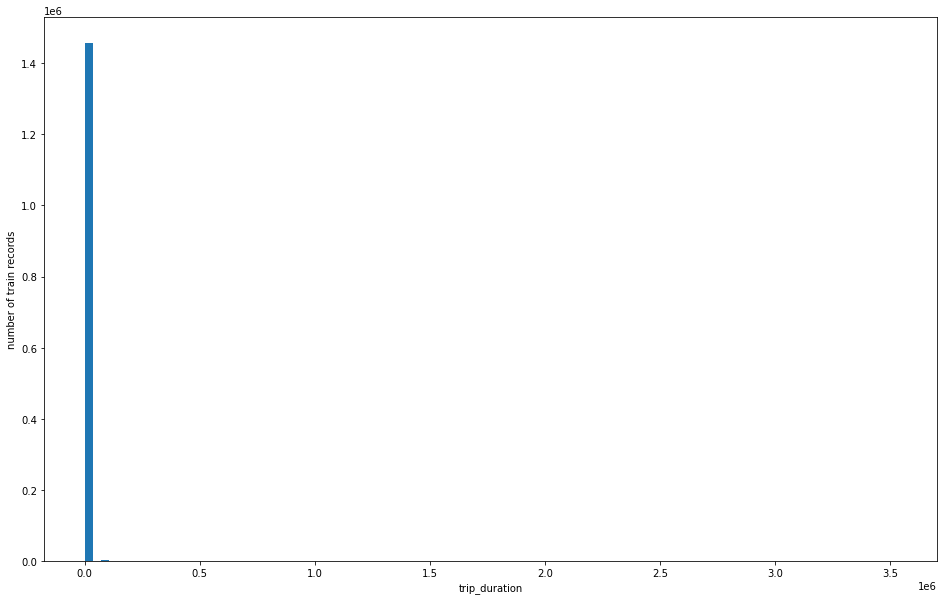

In [23]:
# Ваш код

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно пролагарифмировать целевую переменную.

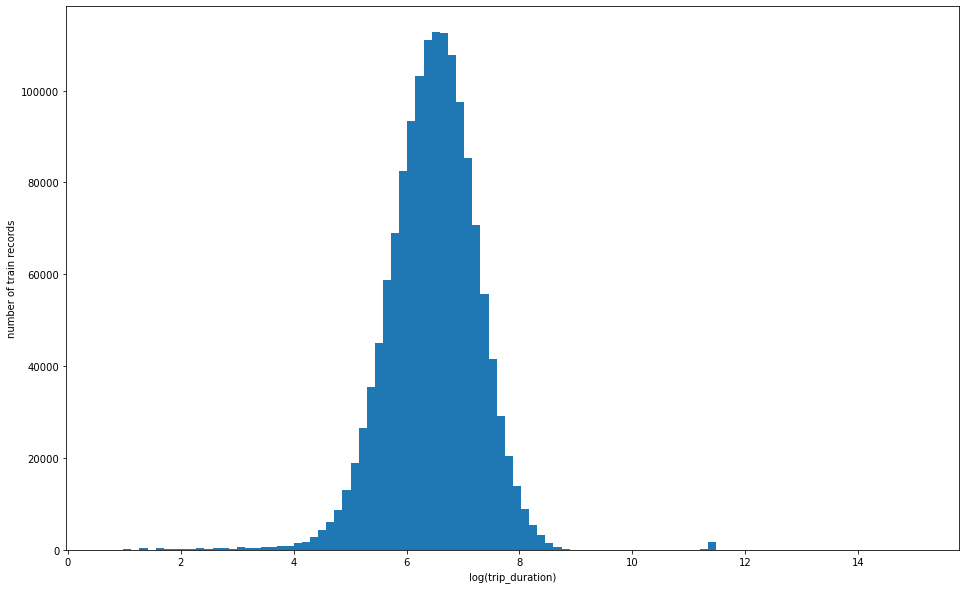

In [37]:
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
# Ваш код

Выглядит гораздо лучше.
А что, если не логарифмировать сразу, а посмотреть на этот длинных хвост внимательнее и поискать там выбросы?


Рассмотрим банальные статистики.

In [27]:
# Ваш код

Минимальное время поездки 1 ; среднее время поездки 959.4922729603659 ; максимальное время поездки 3526282


У нас есть поездки, которые длились более 10 часов. Давайте посмотрим на них.

In [32]:
df[df.trip_duration >= 10 * 3600].trip_duration.sort_values(ascending = False ).head(5)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
Name: trip_duration, dtype: int64

In [23]:
df[df.trip_duration >= 10 * 3600].shape

(2012, 14)

Это выбросы. Мог сломаться таксометр, водитель мог забыть остановить поездку по каким-то причинам и т.д. В любом случае, будет странно обучаться на таких данных, обычно их выкидывают из выборки. Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч.


Таким образом у нас есть 2 пути бороться с тяжелыми хвостами:
1. Логарифмирование
2. Выкидыванеи выбросов

#### Другие числовые признаки

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется haversine distance.

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт манхэттенское расстояние — оно учитывает, что машины всё-таки не летают.

In [47]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
df.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)

Посмотрим на распределения расстояний.

Теперь давайте также, как при анализе целевой переменной построим гистограмму и посмотрим, есть ли тяжелые хвосты у численных пееменных. На самом деле мы можем построить гистограммы сразу для большого много чиса признаков.

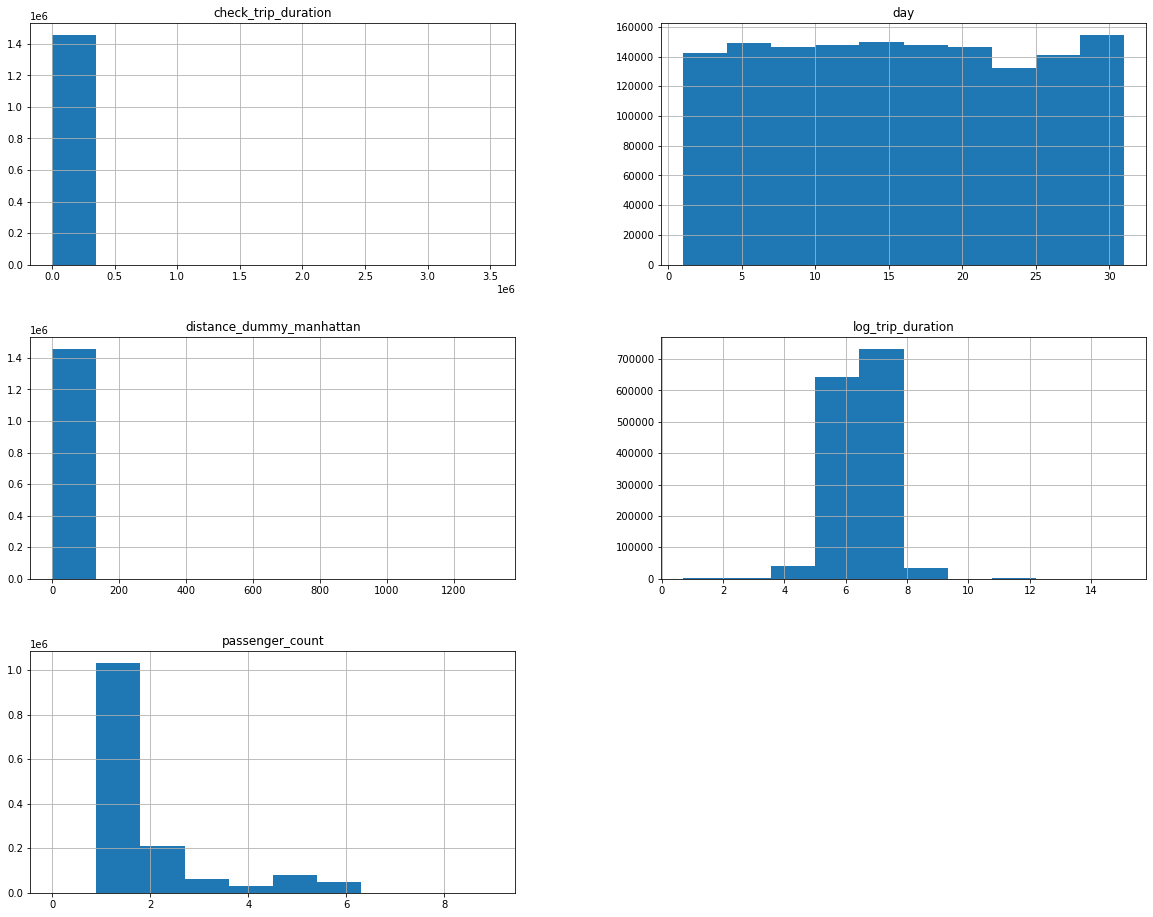

In [48]:
#'trip_duration','log_trip_duration','distance_dummy_manhattan',
df[['log_trip_duration','distance_dummy_manhattan','passenger_count','day','check_trip_duration']].hist(figsize=(20,16));

Видим, что дни недели распределены равномерно, логарифм длинны поездки тоже выглядит нормально, без тяжелых хвостов (мы уже выше с ними расправились), число пассажиров тоже не имеет больших хвостов. А вот расстояние поездки и чек выглядят не очень - один столбик. Тут та же проблема, что была с целевой переменной. Давайте логарифмировать.

In [49]:
df.distance_dummy_manhattan = df.distance_dummy_manhattan.apply(lambda w: np.log(w + 1))
df.check_trip_duration = df.check_trip_duration.apply(lambda w: np.log(w + 1))

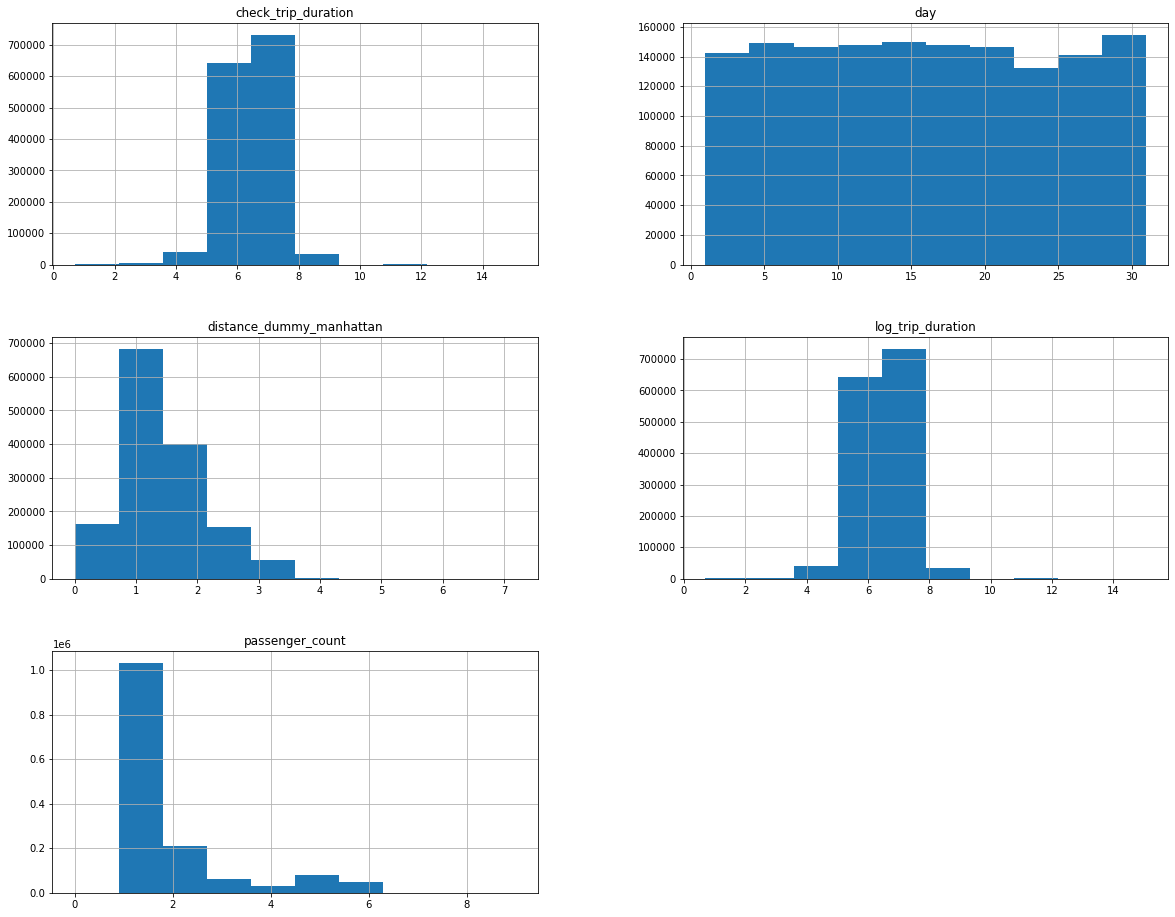

In [50]:
#'trip_duration','log_trip_duration','distance_dummy_manhattan',
df[['log_trip_duration','distance_dummy_manhattan','passenger_count','day','check_trip_duration']].hist(figsize=(20,16));

Хвосты побороли, давайте двигаться дальше. Прикинем визуально, есть ли признаки линейной зависимости между переменными.

Поисследуем теперь связь между расстоянием и продолжительностью поездки (она кажется самой очевидной).

Text(0, 0.5, 'trip duration')

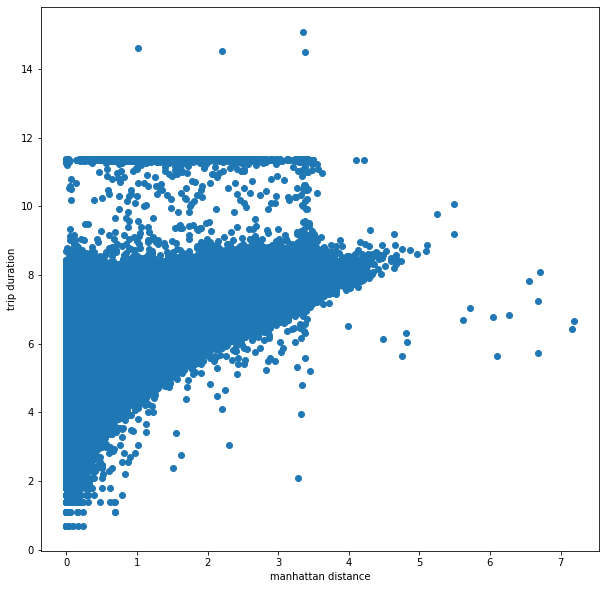

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(df.distance_dummy_manhattan, df.log_trip_duration, marker='o')
plt.xlabel('manhattan distance')
plt.ylabel('trip duration')

Так, визуально можно прикинуть на глаз, есть ли признаки линейной зависимости.

Такой трюк можно провернуть для всех численных переменных за один график. Для этого нам понадобится pairplot из пакета seaborn.

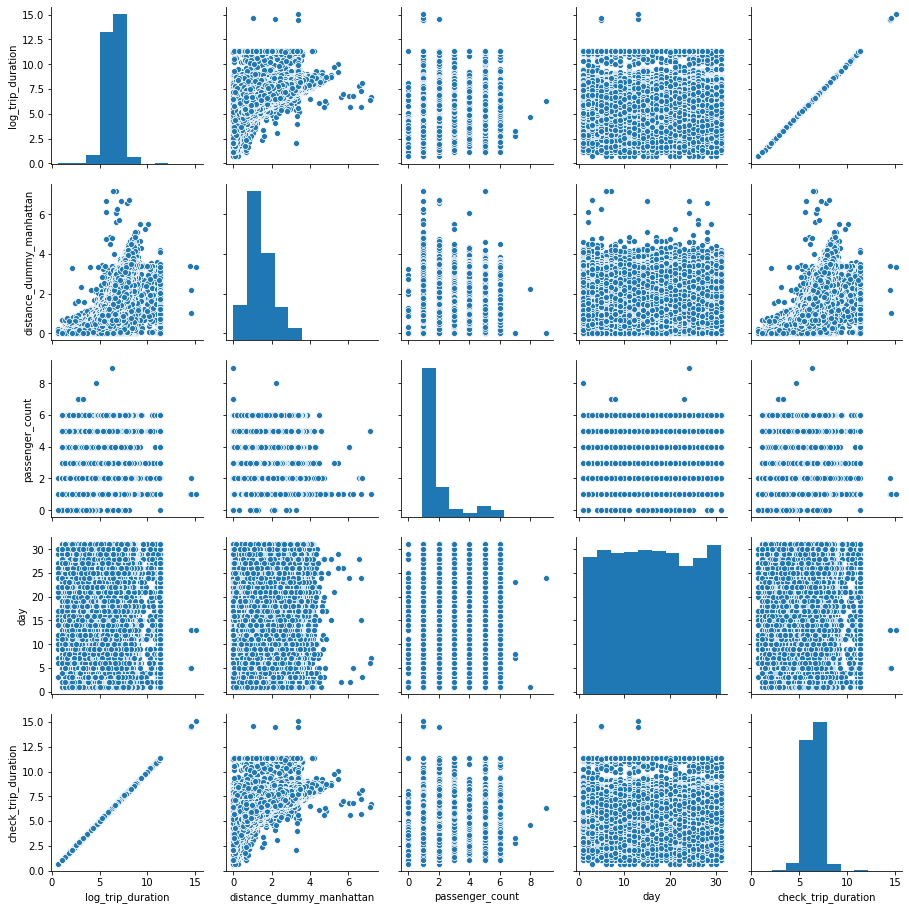

In [55]:
sns.pairplot(df.loc[:,['log_trip_duration','distance_dummy_manhattan','passenger_count','day','check_trip_duration']])